In [466]:
import random
import pickle

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

### Notes on Mixed effects linear models

1. Mixed means a combination of both fixed effects and random effects
2. Fixed and Random effects has little to do with the variables themselves. It arises more from how you pose your research question and experimental design. 
    1. Fixed effect is any variable X that will affect the response variable Y. 
    2. Random effect is better termed "grouping factor"
        1. They are always categorical
        2. Not so interested in how they impact the response variable
        3. More interested in how they influence the patterns we observe
        4. The instances of our random effect are just a sample of all possible. We only sampled 10 Nile rats out of all rats in the lab. 
        5. We want to know how much variance is attributable to the random effect when we predict intensity
            6. We want to control for the effects of selecting those 10 Nile rats randomly, and we want to extend our result to Nile rats in general. 
        6. If we cared about each of the 10 mice specifically (because they were special in some way), then we would model the 10 mice as a fixed effect. 
    3. General rule: random effect should have at least 5 levels.
        1. Any less and you should model it as a fixed effect, e.g. sex (M/F), random-fed/fasted
    4. This is because you want to calculate a variance from your random effect, and any less than 5 data points will lead to questionable variance results.
3. The mixed model answers the question: "Does the correlation between feature intensity and F/R + OGTT exist after controlling for the variation in rats?


## What is the difference between multicolinearity and dependence? 

### Multicolinearity is a type of dependence.

### 1. Multicolinearity occurs when features are non-independent .
####             (e.g. one feature is [M+H]+ and another feature is the corresponding [M+Na]+ adduct

### 2. You can also have dependence when statistical observations are grouped (e.g. multiple observations over several weeks from the same animal)

See the intro of this article https://towardsdatascience.com/how-linear-mixed-model-works-350950a82911

In [30]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 
                            1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', 
                                  sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')
# animal_phenotypes.set_index('animal', inplace=True)

In [31]:
animal_phenotypes['animal']

0     1060
1     1061
2     1062
3     1063
4     1074
5     1075
6     1076
7     1080
8     1081
9     1082
10    1091
11    1092
12    1093
13    1094
14    1095
15    1096
16    1100
17    1101
18    1102
Name: animal, dtype: int32

In [32]:
file_grouping

,analytical_run_order,fr_name,rat_label,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance,bg
File Name,,,,,,,,,,
20210729_AJ_Toh_RatBloodGlucose_Water_R1,1,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (...,NaN,NaN,False,NaN,65,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_Water_R2,2,20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (...,NaN,NaN,False,NaN,66,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_Water_R3,3,20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (...,NaN,NaN,False,NaN,67,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4,20210729_AJ_Toh_RatBloodGlucose_SolventBlank.r...,NaN,NaN,False,NaN,2,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlan...,NaN,NaN,False,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG,63,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...,1062.0,RBG,True,9.0,14,2021-04-01,impaired,250.5
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG,64,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...,1101.0,RBG,True,8.0,54,2021-03-30,diabetic,459.5
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210330_8wk_RBG,65,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...,1092.0,RBG,True,8.0,42,2021-03-30,impaired,76.0


In [628]:
df = fr_filt
df = np.log2(df[fr_quant_filenames_in_analytical_order].T)
fg = file_grouping[file_grouping['fr_name'].isin(fr_quant_filenames_in_analytical_order)]
fg = fg.reset_index()[['fr_name', 'rat_label', 'bg_type', 'glucose_tolerance', 'bg']].set_index('fr_name')
df = df.join(fg)
ogtt_lookup = animal_phenotypes[['animal', 'OGTT (AUC)']]
df['ogtt'] = df['rat_label'].apply(lambda x: ogtt_lookup[ogtt_lookup['animal'] == (int(x))]['OGTT (AUC)'].values[0])
# rename columns to remove '.' because it messes with the formula notation 
new_cols = {}
for col in df.columns:
    new_cols[col] = col.replace('.', '').replace(':', '').replace('-', '')\
    .replace('[', '').replace(']', '')
df = df.rename(new_cols, axis=1)
# df = df.rename({'glucose_tolerance': 'gluc_tol'}, axis=1)
display(df)

,unknown_67905463_0536,unknown_6411087_0537,unknown_95115973_0541,unknown_32903067_0542,unknown_96913147_0544,unknown_62313641_0546,unknown_29108359_0551,unknown_35299652_0553,unknown_24709372_0554,unknown_60514441_0555,...,unknown_89782532_20148,unknown_9749118_20163,unknown_59358716_20175,unknown_87180945_20196,unknown_100393829_20435,rat_label,bg_type,glucose_tolerance,bg,ogtt
20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,18.897008,16.810111,17.724121,18.400646,16.655211,1076.0,FBG,diabetic,71.000000,2321.25
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.348489,17.364343,19.240306,18.585339,16.313637,1062.0,FBG,impaired,52.333333,1648.75
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,21.529536,20.099612,21.430516,20.968101,19.339229,1093.0,FBG,normal,64.000000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,17.921098,18.430542,17.488155,16.202162,17.985491,1060.0,RBG,impaired,225.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.133479,17.986741,19.996615,19.778245,17.357845,1091.0,FBG,normal,48.500000,846.75
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,17.824376,18.099621,17.383197,15.556400,17.582655,1092.0,RBG,impaired,70.500000,1377.95
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,18.836779,18.145468,18.282680,16.603878,17.887551,1093.0,RBG,normal,69.500000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,19.255315,14.496938,19.507853,19.379093,13.846921,1082.0,FBG,diabetic,50.000000,2224.75
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,18.261890,18.854601,17.718258,16.494586,18.466842,1060.0,RBG,impaired,83.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,19.685160,18.324624,19.526233,18.844052,17.739443,1101.0,FBG,diabetic,43.000000,2015.75


In [255]:
# Write the filtered DF for use in R's mixed models packages

df.to_csv(r'..\data\interim\lipids_data_for_R.csv')

In [517]:
feature_columns = df.filter(regex='\d').columns

In [304]:
for feat in feature_columns[:10]:
    print(feat)

unknown_67905463_0536
unknown_6411087_0537
unknown_95115973_0541
unknown_32903067_0542
unknown_96913147_0544
unknown_62313641_0546
unknown_29108359_0551
unknown_35299652_0553
unknown_24709372_0554
unknown_60514441_0555
unknown_3490174_056
unknown_2581102_0572
unknown_93019086_0587
unknown_63810034_0588
unknown_49504285_0599
unknown_34000061_0608
unknown_34199973_0612
unknown_44899011_0667
unknown_54696698_0667
unknown_30502353_0668
unknown_31306619_0668
unknown_56700714_0669
unknown_64901001_067
unknown_36698618_067
unknown_63498871_067
unknown_55298492_0673
unknown_48500394_0676
unknown_4349559_068
unknown_55299005_068
unknown_71096271_0683
unknown_48695691_0689
unknown_6809585_0692
unknown_100489545_0692
unknown_30094617_0692
unknown_80893848_0694
unknown_41897479_0694
unknown_74290997_0695
unknown_67688025_0695
unknown_48092703_0696
unknown_53292566_0699
unknown_45320969_0708
unknown_40918292_0715
unknown_54126349_0716
unknown_55029077_0736
unknown_58528931_0741
unknown_47725003_075

In [348]:
t.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                  MixedLM       Dependent Variable:       PC_182_226_83057001_7881
No. Observations:       60            Method:                   REML                    
No. Groups:             10            Scale:                    0.1033                  
Min. group size:        6             Log-Likelihood:           -25.8689                
Max. group size:        6             Converged:                Yes                     
Mean group size:        6.0                                                             
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                    22.492    0.151 148.502 0.000 22.195 22.789
glucose_tolerance[T.impaired]                -0.035    0.192  -0.181 0.857 -0.410  0.341
glucose_tolerance[T.normal]                  -0.302    0.239  -1.262 0.207 -0.772  0.167
bg_type[T.RBG]                                1.053    0.152   6.949 0.000  0.756  1.350
glucose_tolerance[T.impaired]:bg_type[T.RBG] -0.151    0.192  -0.789 0.430 -0.527  0.224
glucose_tolerance[T.normal]:bg_type[T.RBG]   -0.354    0.240  -1.477 0.140 -0.823  0.116
Group Var                                     0.034    0.092                            
========================================================================================

"""

In [384]:
# print(t.conf_int(alpha=0.05))
print(t.params)
print(t.converged)
print(pd.DataFrame(t.cov_params().values))
# print(t.cov_params())

Intercept                                       22.492020
glucose_tolerance[T.impaired]                   -0.034615
glucose_tolerance[T.normal]                     -0.302142
bg_type[T.RBG]                                   1.052826
glucose_tolerance[T.impaired]:bg_type[T.RBG]    -0.151176
glucose_tolerance[T.normal]:bg_type[T.RBG]      -0.353915
Group Var                                        0.332866
dtype: float64
True


In [418]:
chi_sq_significant = chi2.ppf(q=0.95, df=1)
print(f'Log-likelihood ratio greater than {round(chi_sq_significant, 2)} is significant')

Log-likelihood ratio greater than 3.84 is significant


In [518]:
def get_model_params(feature_name,
                     full_model,
                     no_gluc_tol_model,
                     no_feeding_model,
                     no_cross_model,
                     ):
    d = {}
    d['feature_name'] = feature_name
    
    d['no_gluc_tol_pval'] = np.nan
    d['no_feeding_pval'] = np.nan
    d['no_cross_pval'] = np.nan
    d['no_gluc_tol_fdr_corr'] = np.nan
    d['no_feeding_fdr_corr'] = np.nan
    d['no_cross_fdr_corr'] = np.nan
 
    d['full_model_converged'] = full_model.converged
    d['no_gluc_tol_converged'] = no_gluc_tol_model.converged
    d['no_feeding_converged'] = no_feeding_model.converged
    d['no_cross_converged'] = no_cross_model.converged
    
    d['full_model_ll'] = full_model.llf
    d['no_gluc_tol_ll'] = no_gluc_tol_model.llf
    d['no_feeding_ll'] = no_feeding_model.llf
    d['no_cross_ll'] = no_cross_model.llf
    
    d['full_model_params'] = full_model.params.to_dict()
    d['no_gluc_tol_params'] = no_gluc_tol_model.params.to_dict()
    d['no_feeding_params'] = no_feeding_model.params.to_dict()
    d['no_cross_params'] = no_cross_model.params.to_dict()
    
    
    
    
#     d = {'feature_name': feature_name,
#          'converged': model.converged, 
#          'loglikelihood': model.llf,
#          'model_type': model_type,}
#     if full_model is not None:
#         lrt = 2*(full_model.llf - model.llf) 
#         p_val = chi2.sf(lrt, 1)   # chi-squared Survival Function (gives integral under distribution above value)
#         d['p_val'] =    p_val
#         d['0.05_signif'] = (True if p_val < 0.05 else False)
        
    return d
    

In [609]:
feature_columns

Index(['unknown_67905463_0536', 'unknown_6411087_0537',
       'unknown_95115973_0541', 'unknown_32903067_0542',
       'unknown_96913147_0544', 'unknown_62313641_0546',
       'unknown_29108359_0551', 'unknown_35299652_0553',
       'unknown_24709372_0554', 'unknown_60514441_0555',
       ...
       'unknown_102793848_19865', 'TG_582_96089709_19876',
       'unknown_100192316_19882', 'TG_180_180_180_90886542_19885',
       'unknown_94889648_20144', 'unknown_89782532_20148',
       'unknown_9749118_20163', 'unknown_59358716_20175',
       'unknown_87180945_20196', 'unknown_100393829_20435'],
      dtype='object', length=1029)

In [629]:
# feat = feature_columns[298]
# feat = 'TG_180_180_180_90886542_19885'
# feat = 'unknown_94658014_8407'
feat = 'PlasmanylPC_O160_160_72059094_10096'
# print(feat)
      
# I ~ gluc_tol x F/R + (1|Animal)
full_model = smf.mixedlm(f'{feat} ~ glucose_tolerance * bg_type', 
                         df, groups=df['rat_label']).fit(maxiter=100, reml=False)
# I ~            F/R + (1|Animal)
no_gluc_tol = smf.mixedlm(f'{feat} ~ bg_type', 
                          df, groups=df['rat_label']).fit(maxiter=100, reml=False)
# I ~ gluc_tol       + (1|Animal)
no_feeding = smf.mixedlm(f'{feat} ~ glucose_tolerance', 
                         df, groups=df['rat_label']).fit(maxiter=100, reml=False)
# I ~ gluc_tol + F/R + (1|Animal)
no_cross = smf.mixedlm(f'{feat} ~ glucose_tolerance + bg_type', 
                       df, groups=df['rat_label']).fit(maxiter=100, reml=False)



In [630]:
for model, df in ((no_gluc_tol, 4), (no_feeding, 3), (no_cross, 2)):
    lrt = 2*(full_model.llf - model.llf)
    print(model.converged)
    print(lrt)
    print(chi2.sf(lrt, df), '\n')

True
4.914210922602763
0.2962137981813753 

True
13.077466621082209
0.004472039389707092 

True
0.6740271045033523
0.7138991648960071 



In [519]:
i = 0
rows = []

for feat in feature_columns:
    try:   
        # I ~ gluc_tol x F/R + (1|Animal)
        full_model = smf.mixedlm(f'{feat} ~ glucose_tolerance * bg_type', 
                                 df, groups=df['rat_label']).fit(maxiter=100, reml=False)
        # I ~            F/R + (1|Animal)
        no_gluc_tol = smf.mixedlm(f'{feat} ~ bg_type', 
                                  df, groups=df['rat_label']).fit(maxiter=100, reml=False)
        # I ~ gluc_tol       + (1|Animal)
        no_feeding = smf.mixedlm(f'{feat} ~ glucose_tolerance', 
                                 df, groups=df['rat_label']).fit(maxiter=100, reml=False)
        # I ~ gluc_tol + F/R + (1|Animal)
        no_cross = smf.mixedlm(f'{feat} ~ glucose_tolerance + bg_type', 
                               df, groups=df['rat_label']).fit(maxiter=100, reml=False)
        
        rows.append(get_model_params(feature_name=feat, 
                                     full_model=full_model,
                                     no_gluc_tol_model=no_gluc_tol,
                                     no_feeding_model=no_feeding,
                                     no_cross_model=no_cross))                     
    except LinAlgError:
        print('LinAlgError', i)
        i += 1
        continue  

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parame

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary 

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: Converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary 

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: Converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjander

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarni

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.994762
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(ms

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.938459
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundar

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaco

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.381049
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Convergenc

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.175680
  warnings.warn(msg, ConvergenceWa

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.959925
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.355029
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Convergenc

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\sta

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: Converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaco

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.wa

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.725191
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the est

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\a

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaco

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Con

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.294600
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Convergenc

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Con

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.023327
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.wa

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWar

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\sta

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects cov

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying Mi

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.wa

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.425113
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundar

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg,

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: Converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.150046
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.154828
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the est

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWar

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjander

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarni

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodel

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects cov

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects cov

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.313467
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundar

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaco

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsm

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.477811
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundar

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: Converg

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packag

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.389745
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(ms

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parame

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjander

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjander

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.034080
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Convergenc

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\a

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjander

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.159626
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Convergenc

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary 

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjander

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.452253
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Convergenc

C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.326121
  warnings.warn(msg, ConvergenceWa

In [648]:
result = pd.DataFrame(rows)
# result.to_csv(r'..\data\processed\lipids_mixed_model_fitted.csv')

In [649]:
result

,feature_name,no_gluc_tol_pval,no_feeding_pval,no_cross_pval,no_gluc_tol_fdr_corr,no_feeding_fdr_corr,no_cross_fdr_corr,full_model_converged,no_gluc_tol_converged,no_feeding_converged,no_cross_converged,full_model_ll,no_gluc_tol_ll,no_feeding_ll,no_cross_ll,full_model_params,no_gluc_tol_params,no_feeding_params,no_cross_params
0,unknown_67905463_0536,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,-50.486818,-51.779073,-53.921342,-50.631543,"{'Intercept': 23.08876673856573, 'glucose_tole...","{'Intercept': 23.246996283165636, 'bg_type[T.R...","{'Intercept': 23.33540126351727, 'glucose_tole...","{'Intercept': 23.143849914118785, 'glucose_tol..."
1,unknown_6411087_0537,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,-72.172973,-72.634661,-72.406258,-72.386694,"{'Intercept': 24.345929044832303, 'glucose_tol...","{'Intercept': 24.476783695840005, 'bg_type[T.R...","{'Intercept': 24.418985931878645, 'glucose_tol...","{'Intercept': 24.398334202109833, 'glucose_tol..."
2,unknown_95115973_0541,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,False,-58.740021,-59.070496,-59.911115,-58.874444,"{'Intercept': 23.6237395642576, 'glucose_toler...","{'Intercept': 23.60640305021915, 'bg_type[T.RB...","{'Intercept': 23.79110910183732, 'glucose_tole...","{'Intercept': 23.670089718102098, 'glucose_tol..."
3,unknown_32903067_0542,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,-45.118831,-45.675765,-47.404674,-45.480610,"{'Intercept': 26.718229285201385, 'glucose_tol...","{'Intercept': 26.85818465005639, 'bg_type[T.RB...","{'Intercept': 26.93724303871936, 'glucose_tole...","{'Intercept': 26.80434692699351, 'glucose_tole..."
4,unknown_96913147_0544,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,-57.939698,-59.842514,-61.322888,-59.163429,"{'Intercept': 22.161484274595722, 'glucose_tol...","{'Intercept': 22.438824645125877, 'bg_type[T.R...","{'Intercept': 22.5322447611283, 'glucose_toler...","{'Intercept': 22.355039691383254, 'glucose_tol..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,unknown_89782532_20148,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,False,-63.851195,-74.586030,-90.320241,-73.386198,"{'Intercept': 19.351159796076967, 'glucose_tol...","{'Intercept': 19.71301052450596, 'bg_type[T.RB...","{'Intercept': 19.24044184024289, 'glucose_tole...","{'Intercept': 19.952189857768413, 'glucose_tol..."
1025,unknown_9749118_20163,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,False,-87.781556,-95.492158,-99.051098,-95.194322,"{'Intercept': 17.26299943051246, 'glucose_tole...","{'Intercept': 17.91711518587462, 'bg_type[T.RB...","{'Intercept': 18.483154595823756, 'glucose_tol...","{'Intercept': 18.05597561073659, 'glucose_tole..."
1026,unknown_59358716_20175,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,True,-68.557014,-80.067469,-98.278015,-78.313355,"{'Intercept': 19.389844830849675, 'glucose_tol...","{'Intercept': 19.77659667457865, 'bg_type[T.RB...","{'Intercept': 19.209496151101423, 'glucose_tol...","{'Intercept': 20.077289877702967, 'glucose_tol..."
1027,unknown_87180945_20196,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,False,-71.816459,-83.049413,-119.362967,-80.679959,"{'Intercept': 18.918915957278138, 'glucose_tol...","{'Intercept': 19.14161849214357, 'bg_type[T.RB...","{'Intercept': 18.07545357871267, 'glucose_tole...","{'Intercept': 19.580674462211544, 'glucose_tol..."


In [677]:
for t1, t2 in zip(fdrcorrection(result['no_gluc_tol_pval'].values)[0], 
                  fdrcorrection(result['no_gluc_tol_pval'].values)[1]):
    print(t2, t1)

0.7087825192388898 False
0.940374953892494 False
0.9721160094154707 False
0.9170185059293579 False
0.5459616402732651 False
0.9866327949246857 False
0.9179979475583114 False
0.7114383762813858 False
0.8833325178883726 False
0.9115485488143448 False
0.996158114770214 False
0.9831900951857032 False
0.8060204055399672 False
0.4381446126642611 False
0.8259298407295891 False
0.7057293333413452 False
0.7326133314752638 False
0.10658079849697505 False
0.31161398038053667 False
0.3308163222257344 False
0.5784674328697021 False
0.32545490846731334 False
0.6012139619864633 False
0.9116224101722477 False
0.27723865966425787 False
0.7511804433173813 False
0.42206607353599584 False
0.9199479730134126 False
0.2889439979990366 False
0.6307187949570623 False
0.5854724811167257 False
0.48943305028627143 False
0.6735921454704614 False
0.41055923849972636 False
0.4969954635180813 False
0.4536495758539342 False
0.31061737674436385 False
0.5784674328697021 False
0.309489806016223 False
0.7845274460275314 F

0.26895594194138633 False
0.7845834983941355 False
0.01494501167744768 True
0.14943831109082167 False
0.22721767566458578 False
0.28380827592184416 False
0.29059634142241886 False
0.6916892826981488 False
0.005352968907690495 True
0.378536466914995 False
0.042962583711422205 True
0.3158157979034719 False
0.33918835076959913 False
0.311772185704535 False
0.49569755020426604 False
0.42532849336734674 False
0.829638764911385 False
0.5423209685654441 False
0.8710874361121271 False
0.35409980784626155 False
0.5683534618793696 False
0.7486192115191028 False
0.6958849119721523 False
0.8937184407247465 False
0.8852009455325158 False
0.03564473958697186 True
0.5213368154993712 False
0.6292763333537331 False
0.5699984697432037 False
0.5582037277319005 False
0.9523833961465386 False
0.9109432099327438 False
0.5420040019842884 False
0.9392708820507945 False
0.6273131151890229 False
0.7633921903805165 False
0.11717098380575598 False
0.9749057198449195 False
0.03256362662362989 True
0.11143675508599

In [657]:
### Calculate likelihood ratio test and compare to chi-sq distribution on fitted models MLEs

# likelihood_ratio_test = 2*(full_model.llf - restricted_model.llf) 
# p_val = chi2.sf(lrt, 1)   # chi-squared Survival Function (gives integral under distribution above value)

# result['no_gluc_tol_pval'] = chi2.sf(2*(result['full_model_ll'] - result['no_gluc_tol_ll']), 4)
result['no_gluc_tol_pval'] = result.apply(lambda x: chi2.sf(2*(result['full_model_ll'] - result['no_gluc_tol_ll']), 4))
# result['no_feeding_pval'] = chi2.sf(2*(result['full_model_ll'] - result['no_feeding_ll']), 3)
result['no_feeding_pval'] = result.apply(lambda x: chi2.sf(2*(result['full_model_ll'] - result['no_feeding_ll']), 3))
# result['no_cross_pval'] = chi2.sf(2*(result['full_model_ll'] - result['no_cross_ll']), 2)
result['no_cross_pval'] = result.apply(lambda x: chi2.sf(2*(result['full_model_ll'] - result['no_cross_ll']), 2))

result['no_gluc_tol_fdr_corr'] = fdrcorrection(result['no_gluc_tol_pval'].values)[1]
result['no_feeding_fdr_corr'] = fdrcorrection(result['no_feeding_pval'].values)[1]
result['no_cross_fdr_corr'] = fdrcorrection(result['no_cross_pval'].values)[1]

Text(0.5, 1.0, 'No glucose tolerance\nI ~ F/R + (1|Animal)')

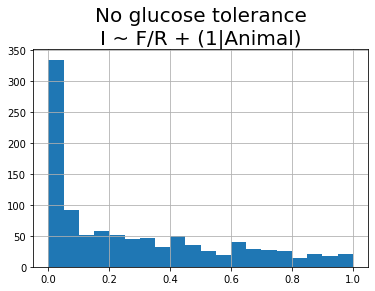

In [665]:
result['no_gluc_tol_fdr_corr'].hist(bins=20)
plt.title('No glucose tolerance\nI ~ F/R + (1|Animal)', fontsize=20)

Text(0.5, 1.0, 'No F/R\nI ~ gluc_tol + (1|Animal)')

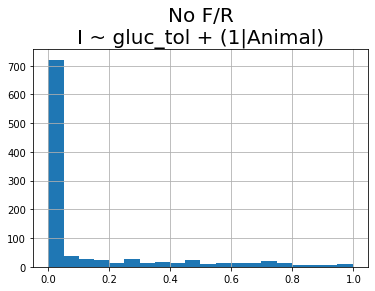

In [664]:
result['no_feeding_fdr_corr'].hist(bins=20)
plt.title('No F/R\nI ~ gluc_tol + (1|Animal)', fontsize=20)

Text(0.5, 1.0, 'No cross\nI ~ gluc_tol + F/R + (1|Animal)')

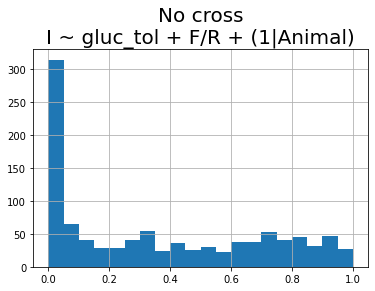

In [663]:
result['no_cross_fdr_corr'].hist(bins=20)
plt.title('No cross\nI ~ gluc_tol + F/R + (1|Animal)', fontsize=20)

In [668]:
result.filter(regex='!unknown')

,feature_name,no_gluc_tol_pval,no_feeding_pval,no_cross_pval,no_gluc_tol_fdr_corr,no_feeding_fdr_corr,no_cross_fdr_corr,full_model_converged,no_gluc_tol_converged,no_feeding_converged,no_cross_converged,full_model_ll,no_gluc_tol_ll,no_feeding_ll,no_cross_ll,full_model_params,no_gluc_tol_params,no_feeding_params,no_cross_params
0,unknown_67905463_0536,0.629570,7.619086e-02,0.865260,0.708783,1.032943e-01,0.916001,True,True,True,True,-50.486818,-51.779073,-53.921342,-50.631543,"{'Intercept': 23.08876673856573, 'glucose_tole...","{'Intercept': 23.246996283165636, 'bg_type[T.R...","{'Intercept': 23.33540126351727, 'glucose_tole...","{'Intercept': 23.143849914118785, 'glucose_tol..."
1,unknown_6411087_0537,0.921184,9.261722e-01,0.807574,0.940375,9.371005e-01,0.881224,True,True,True,True,-72.172973,-72.634661,-72.406258,-72.386694,"{'Intercept': 24.345929044832303, 'glucose_tol...","{'Intercept': 24.476783695840005, 'bg_type[T.R...","{'Intercept': 24.418985931878645, 'glucose_tol...","{'Intercept': 24.398334202109833, 'glucose_tol..."
2,unknown_95115973_0541,0.956056,5.044869e-01,0.874220,0.972116,5.581904e-01,0.923653,True,True,True,False,-58.740021,-59.070496,-59.911115,-58.874444,"{'Intercept': 23.6237395642576, 'glucose_toler...","{'Intercept': 23.60640305021915, 'bg_type[T.RB...","{'Intercept': 23.79110910183732, 'glucose_tole...","{'Intercept': 23.670089718102098, 'glucose_tol..."
3,unknown_32903067_0542,0.892066,2.059844e-01,0.696436,0.917019,2.566077e-01,0.807019,True,True,True,True,-45.118831,-45.675765,-47.404674,-45.480610,"{'Intercept': 26.718229285201385, 'glucose_tol...","{'Intercept': 26.85818465005639, 'bg_type[T.RB...","{'Intercept': 26.93724303871936, 'glucose_tole...","{'Intercept': 26.80434692699351, 'glucose_tole..."
4,unknown_96913147_0544,0.432949,7.972878e-02,0.294131,0.545962,1.078067e-01,0.469970,True,True,True,True,-57.939698,-59.842514,-61.322888,-59.163429,"{'Intercept': 22.161484274595722, 'glucose_tol...","{'Intercept': 22.438824645125877, 'bg_type[T.R...","{'Intercept': 22.5322447611283, 'glucose_toler...","{'Intercept': 22.355039691383254, 'glucose_tol..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,unknown_89782532_20148,0.000256,1.889936e-11,0.000072,0.003723,9.130253e-11,0.002195,True,True,True,False,-63.851195,-74.586030,-90.320241,-73.386198,"{'Intercept': 19.351159796076967, 'glucose_tol...","{'Intercept': 19.71301052450596, 'bg_type[T.RB...","{'Intercept': 19.24044184024289, 'glucose_tole...","{'Intercept': 19.952189857768413, 'glucose_tol..."
1025,unknown_9749118_20163,0.003903,5.037700e-05,0.000603,0.019124,1.055762e-04,0.005308,True,False,True,False,-87.781556,-95.492158,-99.051098,-95.194322,"{'Intercept': 17.26299943051246, 'glucose_tole...","{'Intercept': 17.91711518587462, 'bg_type[T.RB...","{'Intercept': 18.483154595823756, 'glucose_tol...","{'Intercept': 18.05597561073659, 'glucose_tole..."
1026,unknown_59358716_20175,0.000125,7.734824e-13,0.000058,0.002805,4.556605e-12,0.002195,False,False,True,True,-68.557014,-80.067469,-98.278015,-78.313355,"{'Intercept': 19.389844830849675, 'glucose_tol...","{'Intercept': 19.77659667457865, 'bg_type[T.RB...","{'Intercept': 19.209496151101423, 'glucose_tol...","{'Intercept': 20.077289877702967, 'glucose_tol..."
1027,unknown_87180945_20196,0.000162,1.763297e-20,0.000141,0.002872,3.944418e-19,0.002554,True,True,True,False,-71.816459,-83.049413,-119.362967,-80.679959,"{'Intercept': 18.918915957278138, 'glucose_tol...","{'Intercept': 19.14161849214357, 'bg_type[T.RB...","{'Intercept': 18.07545357871267, 'glucose_tole...","{'Intercept': 19.580674462211544, 'glucose_tol..."


In [490]:
restricted_model_result['p_val']

1       1.000000e+00
2       4.055857e-02
3       1.000000e+00
5       6.540700e-01
6       5.985456e-01
            ...     
4110    9.638028e-22
4111    2.540745e-05
4113    3.042378e-05
4114    7.252154e-08
4115    7.681281e-05
Name: p_val, Length: 3087, dtype: float64

In [484]:
restricted_model_result = result.loc[result['model_type'] != 'full']

restricted_model_result[['fdr_correction_is_rejected','adj_p_val']] = \
    fdrcorrection(restricted_model_result['p_val'])

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Must have equal len keys and value when setting with an ndarray

Text(0.5, 1.0, 'I ~ F/R + (1|Animal)')

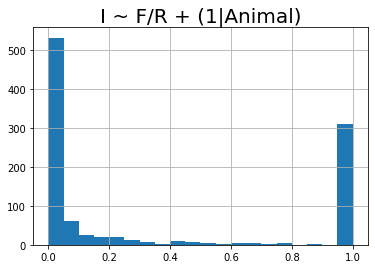

In [463]:
result.loc[(result['model_type'] == 'no_gluc_tol')]['p_val'].hist(bins=20)
plt.title('I ~ F/R + (1|Animal)', fontsize=20)

Text(0.5, 1.0, 'I ~ gluc_tol + (1|Animal)')

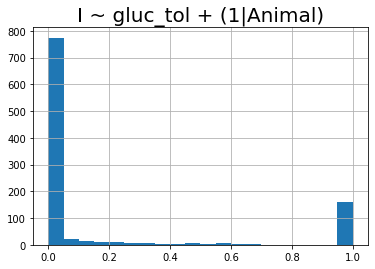

In [464]:
result.loc[(result['model_type'] == 'no_feeding')]['p_val'].hist(bins=20)
plt.title('I ~ gluc_tol + (1|Animal)', fontsize=20)

Text(0.5, 1.0, 'I ~ gluc_tol + F/R + (1|Animal)')

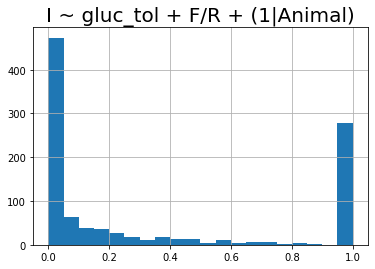

In [461]:
result.loc[(result['model_type'] == 'no_cross')]['p_val'].hist(bins=20)
plt.title('I ~ gluc_tol + F/R + (1|Animal)', fontsize=20)

In [440]:
ll_rows = []

for feat in result['feature_name'].unique():
    full_ll = result.loc[(result['feature_name'] == feat) & (result['model_type'] == 'full')]['loglikelihood'].values[0]
    no_gluc_ll = result.loc[(result['feature_name'] == feat) & (result['model_type'] == 'no_gluc_tol')]['loglikelihood'].values[0]
    no_feed_ll = result.loc[(result['feature_name'] == feat) & (result['model_type'] == 'no_feeding')]['loglikelihood'].values[0]
    no_cross_ll = result.loc[(result['feature_name'] == feat) & (result['model_type'] == 'no_cross')]['loglikelihood'].values[0]
    
    d = {'no_gluc_tol': 2*(full_ll - no_gluc_ll),
         'no_feeding': 2*(full_ll - no_feed_ll),
         'no_cross': 2*(full_ll - no_cross_ll)}
    ll_rows.append(d)

pd.DataFrame(ll_rows)

,no_gluc_tol,no_feeding,no_cross
0,-5.741584,27.788770,-3.476307
1,-4.423254,20.872957,-0.364271
2,-4.106753,56.837249,-1.204336
3,5.665141,14.178552,4.304263
4,-5.058785,3.027972,-2.923391


In [56]:
smf.ols(f"{random_col} ~ ogtt + bg_type", df).fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     TG_180_205_204_94679138_15972   R-squared:                       0.504
Model:                                       OLS   Adj. R-squared:                  0.486
Method:                            Least Squares   F-statistic:                     28.95
Date:                           Thu, 30 Dec 2021   Prob (F-statistic):           2.11e-09
Time:                                   11:38:41   Log-Likelihood:                -75.486
No. Observations:                             60   AIC:                             157.0
Df Residuals:                                 57   BIC:                             163.3
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.6749      0.425     48.639      0.000      19.824      21.526
bg_type[T.RBG]    -0.8228      0.226     -3.648      0.001      -1.274      -0.371
ogtt               0.0016      0.000      6.677      0.000       0.001       0.002
==============================================================================
Omnibus:                        0.897   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.715
Skew:                          -0.265   Prob(JB):                        0.699
Kurtosis:                       2.929   Cond. No.                     6.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [324]:
smf.ols(f"{random_col} ~ glucose_tolerance * bg_type", df).fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     PC_182_226_83057001_7881   R-squared:                       0.671
Model:                                  OLS   Adj. R-squared:                  0.640
Method:                       Least Squares   F-statistic:                     22.00
Date:                      Mon, 03 Jan 2022   Prob (F-statistic):           6.01e-12
Time:                              14:52:50   Log-Likelihood:                -20.780
No. Observations:                        60   AIC:                             53.56
Df Residuals:                            54   BIC:                             66.13
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       22.4920      0.120    187.111      0.000      22.251      22.733
glucose_tolerance[T.impaired]                   -0.0346      0.152     -0.228      0.821      -0.339       0.270
glucose_tolerance[T.normal]                     -0.3021      0.190     -1.590      0.118      -0.683       0.079
bg_type[T.RBG]                                   1.0528      0.170      6.193      0.000       0.712       1.394
glucose_tolerance[T.impaired]:bg_type[T.RBG]    -0.1512      0.215     -0.703      0.485      -0.582       0.280
glucose_tolerance[T.normal]:bg_type[T.RBG]      -0.3539      0.269     -1.317      0.194      -0.893       0.185
==============================================================================
Omnibus:                        9.204   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               11.010
Skew:                           0.602   Prob(JB):                      0.00407
Kurtosis:                       4.719   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
random_col

'PC_182_226_83057001_7881'

In [316]:
# "Y ~ A + B + A:B" is the same formula as "Y ~ A * B"

c = smf.ols(f"{random_col} ~ ogtt + bg_type + ogtt:bg_type", df).fit(maxiter=100)
c.summary()
# c.model.formula

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     PC_182_226_83057001_7881   R-squared:                       0.690
Model:                                  OLS   Adj. R-squared:                  0.673
Method:                       Least Squares   F-statistic:                     41.56
Date:                      Mon, 03 Jan 2022   Prob (F-statistic):           2.88e-14
Time:                              14:51:37   Log-Likelihood:                -18.960
No. Observations:                        60   AIC:                             45.92
Df Residuals:                            56   BIC:                             54.30
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              22.0735      0.228     96.839      0.000      21.617      22.530
bg_type[T.RBG]          0.3216      0.322      0.998      0.323      -0.324       0.967
ogtt                    0.0002      0.000      1.555      0.126   -6.03e-05       0.000
ogtt:bg_type[T.RBG]     0.0004      0.000      1.887      0.064   -2.21e-05       0.001
==============================================================================
Omnibus:                        8.041   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                9.349
Skew:                           0.527   Prob(JB):                      0.00933
Kurtosis:                       4.621   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [331]:
smf.mixedlm(f'PC_182_226_83057001_7881 ~ ogtt * bg_type', df, groups=['rat_label']).fit(maxiter=100)

LinAlgError: Singular matrix

In [320]:
random_col

'PC_182_226_83057001_7881'

In [332]:
t = smf.mixedlm(f"PC_182_226_83057001_7881 ~ glucose_tolerance * bg_type", df, groups=df['rat_label']).fit(maxiter=10)
t.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                  MixedLM       Dependent Variable:       PC_182_226_83057001_7881
No. Observations:       60            Method:                   REML                    
No. Groups:             10            Scale:                    0.1033                  
Min. group size:        6             Log-Likelihood:           -25.8689                
Max. group size:        6             Converged:                Yes                     
Mean group size:        6.0                                                             
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                    22.492    0.151 148.502 0.000 22.195 22.789
glucose_tolerance[T.impaired]                -0.035    0.192  -0.181 0.857 -0.410  0.341
glucose_tolerance[T.normal]                  -0.302    0.239  -1.262 0.207 -0.772  0.167
bg_type[T.RBG]                                1.053    0.152   6.949 0.000  0.756  1.350
glucose_tolerance[T.impaired]:bg_type[T.RBG] -0.151    0.192  -0.789 0.430 -0.527  0.224
glucose_tolerance[T.normal]:bg_type[T.RBG]   -0.354    0.240  -1.477 0.140 -0.823  0.116
Group Var                                     0.034    0.092                            
========================================================================================

"""

### Because every animal has one unique OGTT value (continuous value), that OGTT value and the animal number are counfounders. 

### Therefore a model of `Intensity ~ OGTT  x  bg_type + (1|Animal)` is not valid.

### In this case, use only fixed effects (i.e. a regular linear model) with `Intensity ~ OGTT x bg_type`

In [278]:
random_col = random.choice(df.drop(df.filter(regex='unknown').columns, axis=1).columns)

##### not statistically sound:
##### lmem_continuous = smf.mixedlm(f"{random_col} ~ ogtt * bg_type", df, groups=df['rat_label']).fit(maxiter=100) 

lm_continuous = smf.ols(f"{random_col} ~ ogtt * bg_type", df).fit(maxiter=100)
lm_categorical = smf.ols(f"{random_col} ~ glucose_tolerance * bg_type", df).fit(maxiter=100)
lmem_categorical = smf.mixedlm(f"{random_col} ~ glucose_tolerance * bg_type", 
                               df, groups=df['rat_label']).fit(maxiter=100)
print(random_col, '\n')
print(lm_continuous.summary(), "\n\n")
print(lm_categorical.summary(), '\n\n')
print(lmem_categorical.summary())

### lm_categorical and lmem_categorical parameters will be identical ###

PC_182_226_83057001_7881 

                               OLS Regression Results                               
Dep. Variable:     PC_182_226_83057001_7881   R-squared:                       0.690
Model:                                  OLS   Adj. R-squared:                  0.673
Method:                       Least Squares   F-statistic:                     41.56
Date:                      Mon, 03 Jan 2022   Prob (F-statistic):           2.88e-14
Time:                              14:34:33   Log-Likelihood:                -18.960
No. Observations:                        60   AIC:                             45.92
Df Residuals:                            56   BIC:                             54.30
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Overall formula (expansion of the `*` used in formula notation)
#### `Intensity ~ (Beta1*glucose_tolerance) + (Beta2*feeding_bg_type) + (Beta3 * gluc_tol * bg_type)`

TG_546_89677039_16154
Intercept                                       26.638486
glucose_tolerance[T.impaired]                    0.283872
glucose_tolerance[T.normal]                      0.012351
bg_type[T.RBG]                                   0.044934
glucose_tolerance[T.impaired]:bg_type[T.RBG]    -1.459384
glucose_tolerance[T.normal]:bg_type[T.RBG]      -1.779423
Group Var                                        0.804769
dtype: float64
1.4210854715202004e-14
1.4210854715202004e-14


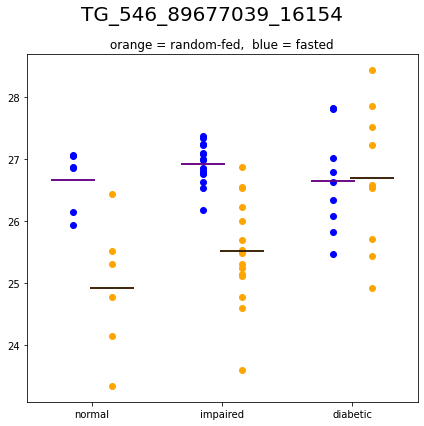

In [235]:
# Using categorical Diabetes type (normal vs. impaired vs. diabetic)

d = {'normal':   {'RBG':None, 'FBG':None}, 
     'impaired': {'RBG':None, 'FBG':None},
     'diabetic': {'RBG':None, 'FBG':None},}

for gluc_tol in ['normal', 'impaired', 'diabetic']:
    for bg_type in ['RBG', 'FBG']:
        mean = df.loc[(df['glucose_tolerance'] == gluc_tol) & (df['bg_type'] == bg_type)][random_col].mean()
        d[gluc_tol][bg_type] = mean

print(random_col)
fig = plt.gcf()
fig.set_size_inches(6, 6)
fig.suptitle(random_col, fontsize=20)
ax = plt.subplot(111)
ax.set_xlim((-0.5, 2.5))
ax.set_title('orange = random-fed,  blue = fasted', fontsize=12)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['normal', 'impaired', 'diabetic'])
offset = 0.15

for i, animal in enumerate(animals_used):    
    gluc_tol_type = animal_to_tolerance_dict[animal]
    if gluc_tol_type == 'normal':
        gluc_tol_type_position = 0
    elif gluc_tol_type == 'impaired':
        gluc_tol_type_position = 1
    elif gluc_tol_type == 'diabetic':
        gluc_tol_type_position = 2

#     ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + str(ogtt_value) + ' OGTT')
#     ax.set_xticks([1,2])
#     ax.set_xticklabels( ['Random', 'Fasted'])
    
    for j, bg_type in enumerate(['RBG', 'FBG']):
        data = df[(df['rat_label'] == animal) & (df['bg_type'] == bg_type)][random_col]
        color = ('orange' if j == 0 else 'blue')
        offset_ = (offset if bg_type == 'RBG' else -offset)
        ax.scatter(x=len(data)*[gluc_tol_type_position + offset_] , 
                   y=data,
                   color=color)
        
params = lmem_categorical.params

# FBG is the main value. RBG uses the 'bg_type[T.RBG]' correction
# Diabetic is the main value, then there are corrections for glucose_tolerance[T.impaired], glucose_tolerance[T.normal]
diabetic_fbg = params['Intercept']
diabetic_rbg = params['Intercept'] + params['bg_type[T.RBG]']

impaired_fbg = diabetic_fbg + params['glucose_tolerance[T.impaired]']
impaired_rbg = diabetic_rbg + params['glucose_tolerance[T.impaired]'] + params['glucose_tolerance[T.impaired]:bg_type[T.RBG]']

normal_fbg = diabetic_fbg + params['glucose_tolerance[T.normal]']
normal_rbg = diabetic_rbg + params['glucose_tolerance[T.normal]'] + params['glucose_tolerance[T.normal]:bg_type[T.RBG]']

plt.scatter([2 - offset], [diabetic_fbg], color='darkblue', s=2000, marker='_')
plt.scatter([2 + offset], [diabetic_rbg], color='darkorange', s=2000, marker='_')
plt.scatter([1 - offset], [impaired_fbg], color='darkblue', s=2000, marker='_')
plt.scatter([1 + offset], [impaired_rbg], color='darkorange', s=2000, marker='_')
plt.scatter([0 - offset], [normal_fbg  ], color='darkblue', s=2000, marker='_')
plt.scatter([0 + offset], [normal_rbg  ], color='darkorange', s=2000, marker='_')

plt.scatter([2 - offset], [d['diabetic']['FBG']], color='purple', s=2000, marker='_')
plt.scatter([2 + offset], [d['diabetic']['RBG']], color='black', s=2000, marker='_')
plt.scatter([1 - offset], [d['impaired']['FBG']], color='purple', s=2000, marker='_')
plt.scatter([1 + offset], [d['impaired']['RBG']], color='black', s=2000, marker='_')
plt.scatter([0 - offset], [d['normal'  ]['FBG']], color='purple', s=2000, marker='_')
plt.scatter([0 + offset], [d['normal'  ]['RBG']], color='black', s=2000, marker='_')

plt.tight_layout()
print(params)

print(abs(d['normal']['RBG'] - normal_rbg))
print(abs(d['normal']['FBG'] - normal_fbg))

## Method overview for significance testing the mixed and fixed models from feature intensities 

### Likelihood ratio test

* Standard method for comparison of models is the likelihood ratio test (LRT)
    * $LR = 2(logL(\hat\theta_F) - logL(\hat\theta_R))$  Where $logL$ = log-likelihood, $F$ = Full set of parameters and $R$ = Restricted set of parameters (i.e. the simpler model with fewer parameters)
    * LR is asymptotically distributed as a $\chi^2$ with df = # of parameters removed between Full and Restricted (not the total number of parameters)
    * Note that mixed effects model fit should be estimated with REML (Restricted Maximum Likelihood) rather than regular ML. 
    * Good resources for more info:
        * https://stats.stackexchange.com/questions/48671/what-is-restricted-maximum-likelihood-and-when-should-it-be-used
        * http://web.pdx.edu/~newsomj/mlrclass/ho_LR%20tests.pdf
        * https://www.ssc.wisc.edu/sscc/pubs/MM/MM_TestEffects.html#testing-mixed-models-parameters
        * This is because ML is a biased estimator of variance:
            * $\hat\sigma_{ML}^2 = \frac{(n-1)}{n}  \sigma^2$
        * Also, REML is preferred for small sample sizes 
        * Note: performing likelihood ratio test with REML requires that the same fixed effects are specified in both models. 
            * If different fixed effects are specified between two compared models, then use regular ML for LRT

### Procedure:

1. Calculate the following models and summary tables into DFs:
    1. Intensity ~ glucose_tolerance x Fasted/Random   (glucose_tolerance is categorical, vs OGTT which is continuous)
    2. Intensity ~ glucose_tolerance x Fasted/Random + (1|Animal)  (Constant slope, different intercept)
    3. Intensity ~ glucose_tolerance x Fasted/Random + (glucose_tolerance|Animal)
    
2. For each feature, do the likelihood ratio test (above) between REML values from each model
    * Compare value against chi_squared test
    
3. Perform FDR correction on the significance values 

In [254]:
chi2.ppf(q=0.999999, df=1)

23.92812697687947

PlasmanylPC_O344_74056061_8327
Intercept              21.429883
bg_type[T.RBG]         -4.275858
ogtt                    0.001156
ogtt:bg_type[T.RBG]     0.001550
Group Var               0.491407
dtype: float64


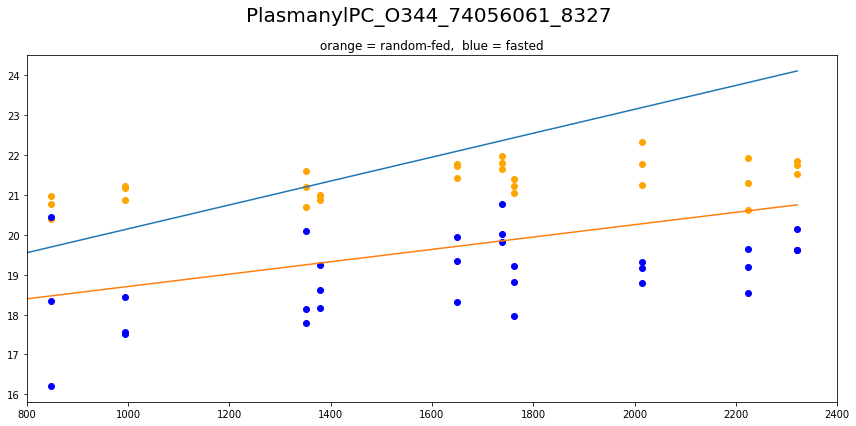

In [119]:
# Attempts at fitting the continuous OGTT value 

print(random_col)
for i, animal in enumerate(animals_used):
    ax = plt.subplot(111)
    ax.set_xlim((800, 2400))
    ogtt_value = animal_phenotypes.loc[animal_phenotypes['animal'] == animal, 'OGTT (AUC)']
    ax.set_title('orange = random-fed,  blue = fasted', fontsize=12)
#     ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + str(ogtt_value) + ' OGTT')
#     ax.set_xticks([1,2])
#     ax.set_xticklabels( ['Random', 'Fasted'])
    data = df[[random_col, 'rat_label', 'bg_type', 'ogtt']]
    
    for j, bg_type in enumerate(['RBG', 'FBG']):
        color = 'orange' if j == 0 else 'blue'
        ax.scatter(3*[ogtt_value], df[random_col].filter(regex=(str(animal))).filter(regex=bg_type), color=color)

intercept = lmem_continuous.params['Intercept']
bg_typeTRBG = lmem_continuous.params['bg_type[T.RBG]']
ogtt = lmem_continuous.params['ogtt']
ogttbgtype = lmem_continuous.params['ogtt:bg_type[T.RBG]']
re = lmem_continuous.random_effects

plt.plot([0, 2321.25], [(intercept + bg_typeTRBG), intercept + 2321.25 * ogtt])  
plt.plot([0, 2321.25], [(intercept + bg_typeTRBG), (intercept + bg_typeTRBG) + 2321.25 * (ogttbgtype)])

        
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.suptitle(random_col, fontsize=20)
plt.tight_layout()
print(lmem_continuous.params)

TG_532_89081793_1815


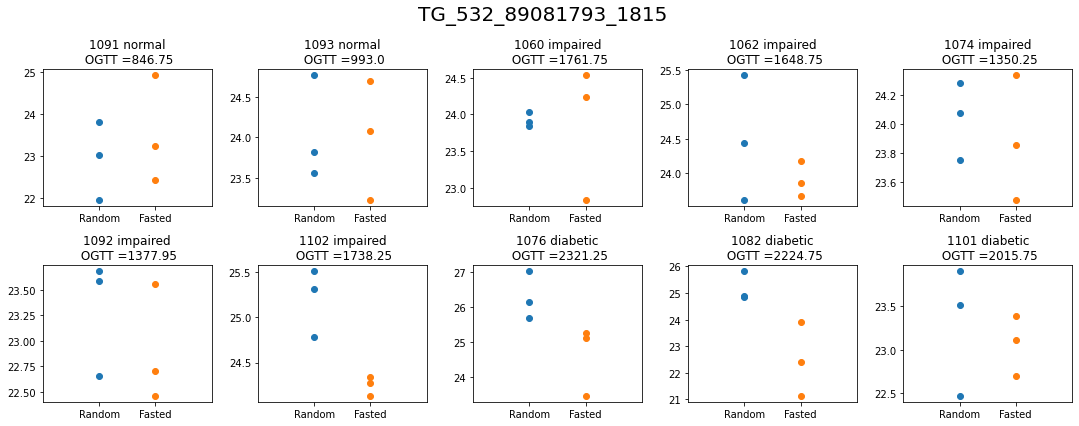

In [112]:
print(random_col)
for i, animal in enumerate(animals_used):
    ax = plt.subplot(2, 5, i+1)
    ax.set_xlim((0, 3))
    ogtt_value = animal_phenotypes.loc[animal_phenotypes['animal'] == animal, 'OGTT (AUC)'].values[0]
    ax.set_title(str(animal) + ' ' + str(animal_to_tolerance_dict[animal]) + '\n' + ' OGTT =' + str(ogtt_value))
    ax.set_xticks([1,2])
    ax.set_xticklabels( ['Random', 'Fasted'])
    for j, bg_type in enumerate(['RBG', 'FBG']):
        
        
        
        ax.scatter(3*[j+1], df[random_col].filter(regex=(str(animal))).filter(regex=bg_type))
        
        
# plt.xticks(range(1,11), [str(animal) for animal in animals_used]);
fig = plt.gcf()
fig.set_size_inches(15, 6)
fig.suptitle(random_col, fontsize=20)
plt.tight_layout()